In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib
from openpyxl import load_workbook
from imblearn.over_sampling import SMOTE
from collections import Counter

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Bibliotecas dos Modelos Utilizados
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [3]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [4]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Manobrabilidade'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Manobrabilidade
0,1375.000000,1320.000000,1275.000000,1550.000000,2050.000000,570.000000,69.068493,95.743105,0.417540,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1437.352834,1301.084856,1257.383792,1526.436265,2065.013452,512.661006,68.164649,98.483069,0.417531,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1352.624255,1320.913741,1182.351714,1606.885444,2077.082448,566.917181,69.938385,103.583059,0.415100,0.505086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1307.150880,1511.199063,1282.562627,1611.635996,1982.262142,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1393.831096,1408.554269,1398.255323,1554.642728,1946.073774,497.782392,84.085097,125.785803,0.401552,0.503254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
# Linha a ser adicionada
linha = "1380,0000/ 1300/ 1190,0000/ 1551,7200/ 1880/ 469,6/ 114,32/ 86,58/ 0,432/ 0,519/ 629,4/ 788,8/ 189,6000/ 170/ 62/ 22,0000/ 0/ 0/ 245/ 62/ 22/ 0/ 0/ 2/ 69,4/6,8000/ 15/ 39/ 370,3/ 81/ 180/ 52/ 160,0000/ 7,0800/ 20,7/ 38/ 9,5/ 2080/ 30/ 6,4699/ 8,7287/ 3,6/ 0/ 0/ 43/ 41/ 4,2/ 4,4/ 5/"

# Separar os valores da linha
valores = linha.split("/")

# Converter os valores para float
valores_float = [float(valor.replace(",", ".")) for valor in valores[:-1]]

# Adicionar a nova linha ao final do DataFrame existente
df.loc[len(df)] = valores_float

# Verificar o DataFrame atualizado
print(df)

      DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0       1375.000000          1320.000000         1275.000000  1550.000000   
1       1437.352834          1301.084856         1257.383792  1526.436265   
2       1352.624255          1320.913741         1182.351714  1606.885444   
3       1307.150880          1511.199063         1282.562627  1611.635996   
4       1393.831096          1408.554269         1398.255323  1554.642728   
...             ...                  ...                 ...          ...   
996     1500.000000          1297.592843         1210.496743  1464.867874   
997     1514.746926          1261.565233         1191.948088  1533.951251   
998     1371.353579          1302.745066         1202.325865  1534.546076   
999             NaN                  NaN                 NaN          NaN   
1000    1380.000000          1300.000000         1190.000000  1551.720000   

      DP_Comprimento  DP_Altura do CG com relacao ao chao  MV_Eixo dianteir

In [6]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'SD_Curso Positivo de projeto',
    'SD_Curso Negativo de projeto',
    'SD_Dimensoes dos pneus',
    'ST_Curso Positivo de projeto',
    'ST_Curso Negativo de projeto',
    'ST_Dimensoes dos pneus',
    'FD_Pressao no sistema a 07g ',
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Pressao no sistema a 07g ',
    'FT_Diametro do disco ',
    'MT_Potência maxima do motor',
    'MT_Torque maximo do motor',
    'MT_Relacao total_max',
    'MT_Relacao total_min',
    'CD_Distancia de frenagem de 35 a 0 em asfalto',
    'CD_Distancia de frenagem de 35 a 0 em terra batida',
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
    'CD_Tempo para atingir velocidade maxima em asfalto', 
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [7]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 29 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   DP_Entre-Eixo                                            753 non-null    float64
 1   DP_Bitola Dianteira                                      753 non-null    float64
 2   DP_Bitola Traseira                                       753 non-null    float64
 3   DP_Altura                                                753 non-null    float64
 4   DP_Comprimento                                           753 non-null    float64
 5   DP_Altura do CG com relacao ao chao                      211 non-null    float64
 6   MV_Eixo dianteiro                                        731 non-null    float64
 7   MV_Eixo Traseiro                                         731 non-null    float64
 8   DMV_Dianteira               

In [8]:
# Descrição de dados
df.describe()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,D_Inclinacao do pino mestre,D_Angulo de caster,CD_Raio mínimo de curva do protótipo,CD_Velocidade crítica para uma curva de raio de 10 m,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em terra batida,P_Manobrabilidade
count,753.000000,753.000000,753.000000,753.000000,753.000000,211.000000,731.000000,731.000000,731.000000,211.000000,...,166.000000,169.000000,80.000000,24.000000,34.000000,23.000000,21.000000,300.000000,234.000000,1001.000000
mean,1429.122613,1316.595298,1236.264834,1529.642371,1997.354311,520.145312,72.532234,103.648233,0.412078,0.507671,...,9.401191,13.139522,28.039756,50.419481,3.029775,3.484753,3.774950,49.897789,8.037425,3.001998
std,47.084934,81.928964,75.443827,237.213456,68.387607,93.334073,10.637957,11.907017,0.026900,0.048344,...,3.484620,3.240874,232.320632,25.512305,1.427093,3.520786,1.874778,4.728901,5.011366,1.415626
min,1300.000000,633.525807,779.185251,284.003108,1769.958834,186.412435,47.074351,78.901171,0.317764,0.170525,...,0.875795,5.523538,1.388713,27.080000,0.116048,0.000000,0.000000,35.933263,3.640437,1.000000
25%,1398.090115,1279.953411,1199.679417,1488.541619,1970.000000,483.288510,67.161275,95.323140,0.396158,0.491636,...,6.472142,11.037905,1.751831,28.163446,2.140640,1.222471,3.148774,47.297965,4.863800,2.000000
50%,1427.110113,1304.378040,1223.789036,1535.837539,2003.848514,515.369133,71.011527,104.647717,0.411081,0.500000,...,9.121251,13.731422,1.923372,40.754993,2.622836,1.482230,3.262756,50.749618,6.285469,3.000000
75%,1463.091718,1353.207641,1270.867613,1596.599770,2036.840515,555.759886,77.524358,109.805550,0.430798,0.514267,...,12.243447,15.896983,2.205020,66.339479,4.270790,6.430000,3.590000,53.140509,9.350991,4.000000
max,1581.999822,1596.088802,1490.000000,2366.353799,2151.967468,1022.114272,129.074739,154.486862,0.482281,0.650000,...,16.734271,19.804663,2080.000000,99.658516,6.689736,13.587500,10.119773,60.657918,27.025616,5.000000


In [9]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.") 

'DP_Entre-Eixo' tem 0.
'DP_Bitola Dianteira' tem 0.
'DP_Bitola Traseira' tem 0.
'DP_Altura' tem 0.
'DP_Comprimento' tem 0.
'DP_Altura do CG com relacao ao chao' tem 0.
'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'DMV_Lado Direito' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 17.
'PCG_Z' tem 0.
'SD_Cambagem estatica' tem 132.
'SD_Convergência estatica' tem 134.
'ST_Cambagem estatica' tem 123.
'ST_Convergência estatica' tem 115.
'D_Relacao' tem 0.
'D_Curso total da cremalheira' tem 0.
'D_Inclinacao do pino mestre' tem 0.
'D_Angulo de caster' tem 0.
'CD_Raio mínimo de curva do protótipo' tem 0.
'CD_Velocidade crítica para uma curva de raio de 10 m' tem 0.
'CD_Ganho de rolagem por aceleracao lateral' tem 0.
'CD_Ganho de arfagem em aceleracao longitudinal' tem 1.
'CD_Ganho de arfagem em desaceleracao longitudinal' tem 1.
'CD_Velocidade maxima de 0 a 100 metros em terra batida ' tem 0.
'CD_Tempo para atingir velocidade maxima em terra batida' tem 0.
'P_Manobrabilidade' t

## Limpeza

In [10]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 700 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

DP_Entre-Eixo          248
DP_Bitola Dianteira    248
DP_Bitola Traseira     248
DP_Altura              248
DP_Comprimento         248
MV_Eixo dianteiro      270
MV_Eixo Traseiro       270
DMV_Dianteira          270
PCG_X                  270
PCG_Y                   22
PCG_Z                  270
D_Relacao              444
P_Manobrabilidade        0
dtype: int64

In [11]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 8]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([ 13,  23,  27,  35,  37,  38,  40,  41,  50,  54,
            ...
            975, 978, 979, 980, 983, 988, 991, 992, 994, 999],
           dtype='int64', length=248)
      DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0       1375.000000          1320.000000         1275.000000  1550.000000   
1       1437.352834          1301.084856         1257.383792  1526.436265   
2       1352.624255          1320.913741         1182.351714  1606.885444   
3       1307.150880          1511.199063         1282.562627  1611.635996   
4       1393.831096          1408.554269         1398.255323  1554.642728   
...             ...                  ...                 ...          ...   
995     1458.353300          1291.303150         1196.160187  1391.839336   
996     1500.000000          1297.592843         1210.496743  1464.867874   
997     1514.746926          1261.565233         1191.948088  1533.951251   
998     1371.353579          1302.745066         12

In [12]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Manobrabilidade'] = df['P_Manobrabilidade'].replace(mapeamento)

print(df['P_Manobrabilidade'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
995     4.0
996     4.0
997     4.0
998     4.0
1000    4.0
Name: P_Manobrabilidade, Length: 753, dtype: float64


In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Aceleration', index=False)

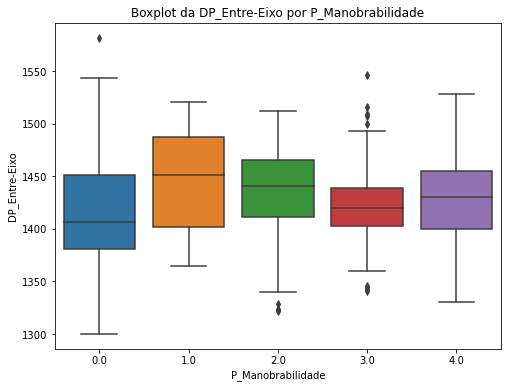

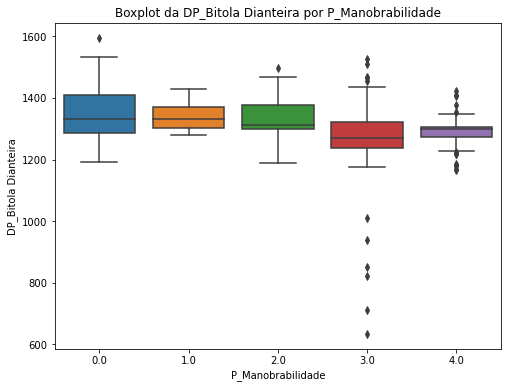

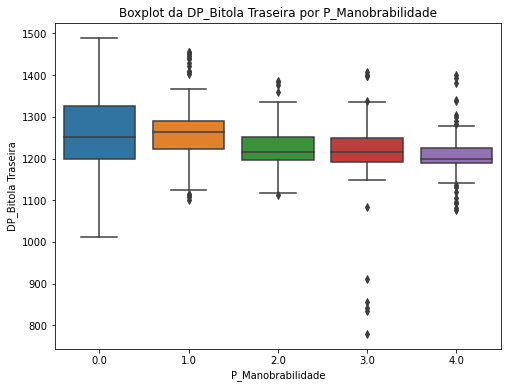

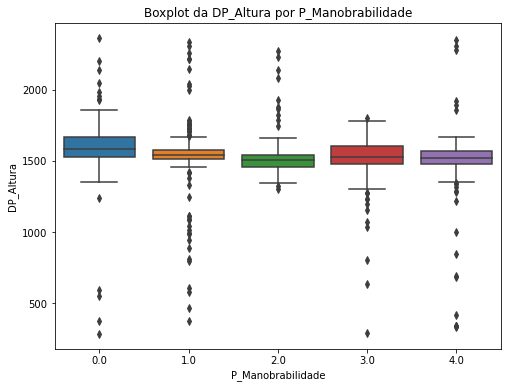

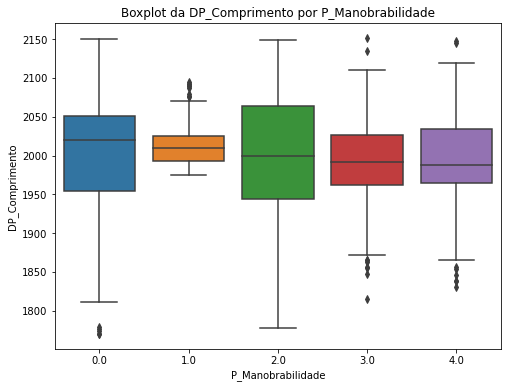

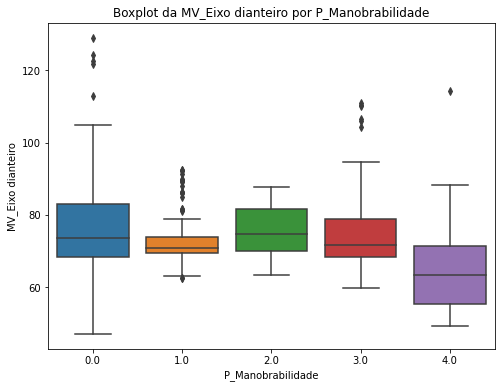

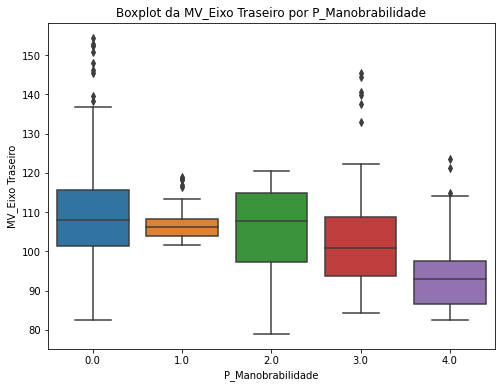

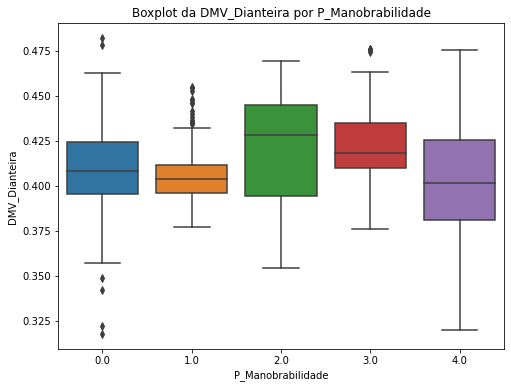

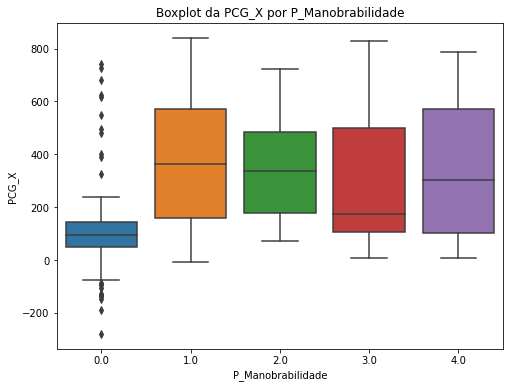

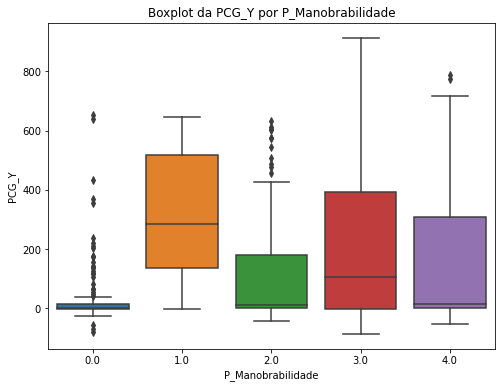

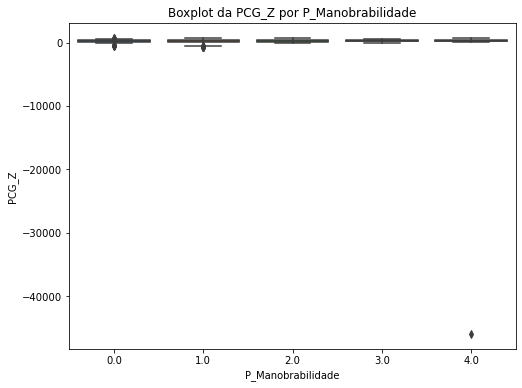

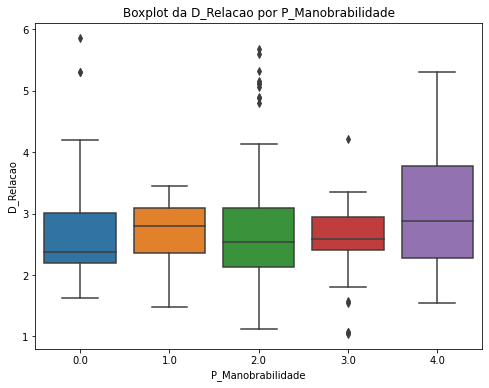

In [13]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Manobrabilidade':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Manobrabilidade', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Manobrabilidade')
        plt.ylabel(coluna)
        plt.xlabel('P_Manobrabilidade')
        plt.show()

In [14]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Manobrabilidade']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Manobrabilidade'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Manobrabilidade'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (2 * desvio_padrao)
    limite_inferior = mediana - (2 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Manobrabilidade'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

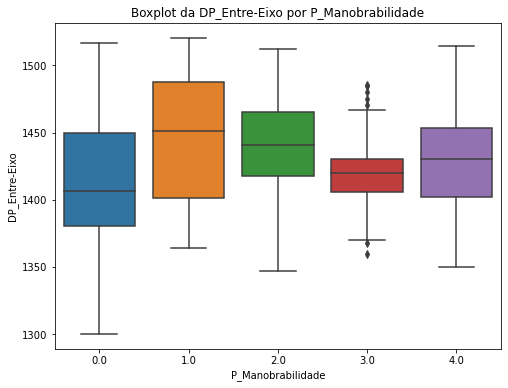

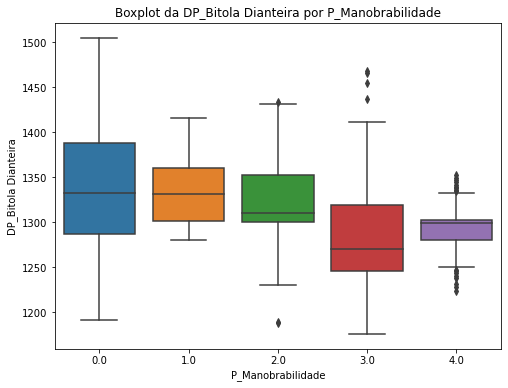

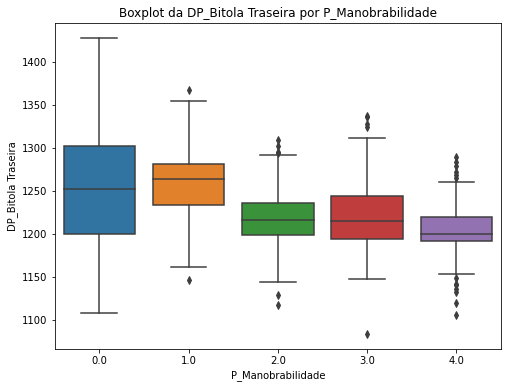

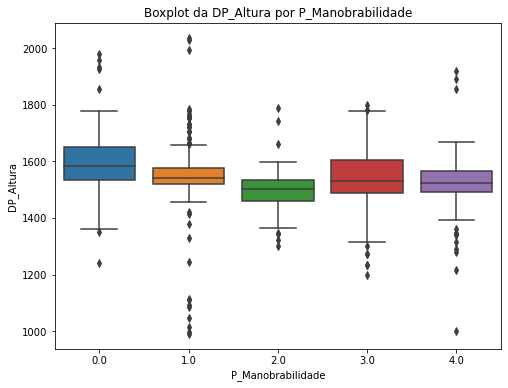

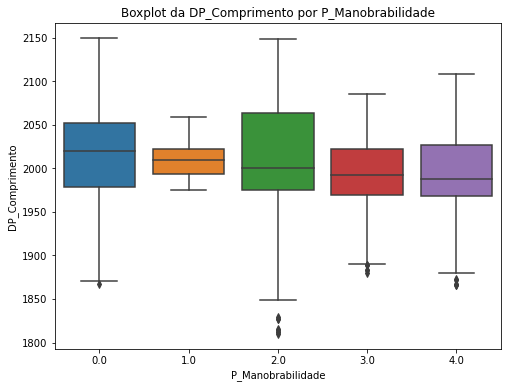

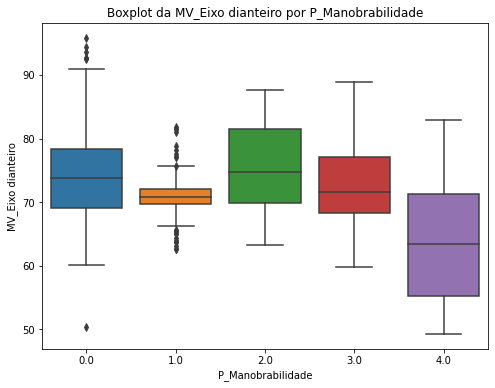

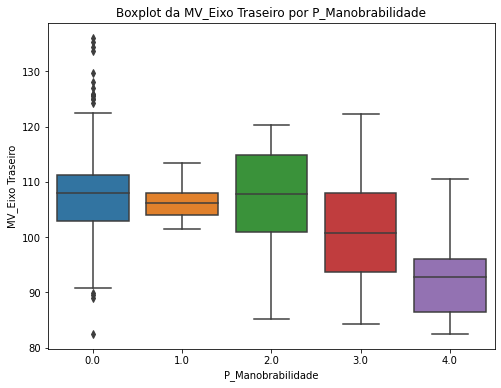

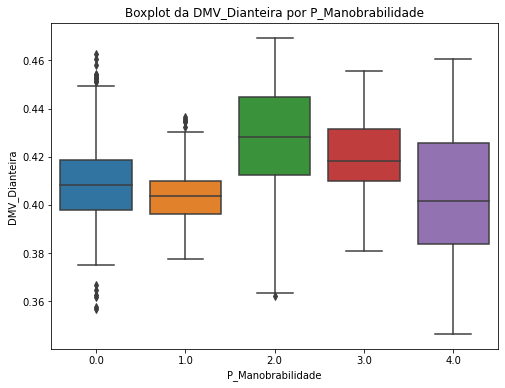

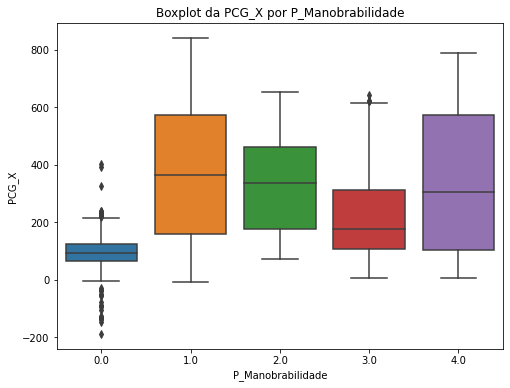

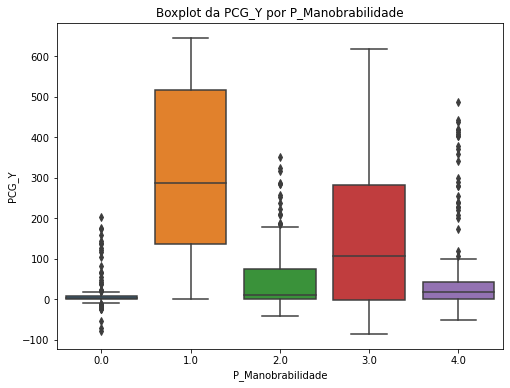

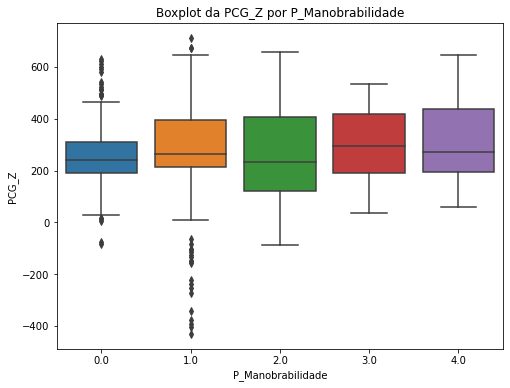

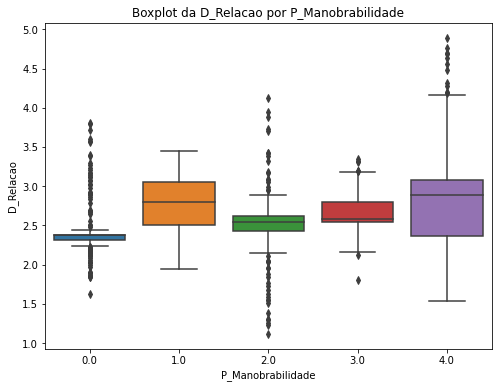

In [15]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Manobrabilidade':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Manobrabilidade', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Manobrabilidade')
        plt.ylabel(coluna)
        plt.xlabel('P_Manobrabilidade')
        plt.show()

In [16]:
df = df_tratado

In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Carregar o arquivo Excel existente
book = load_workbook(caminho_arquivo)

# Adicionar o DataFrame como um novo sheet
with pd.ExcelWriter(caminho_arquivo, engine='openpyxl', mode='a') as writer:
    writer.book = book
    novo_dataframe.to_excel(writer, sheet_name='P_Velocidade', index=False)

## Análise de Variáveis

In [17]:
data_corr = df.drop(['P_Manobrabilidade'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

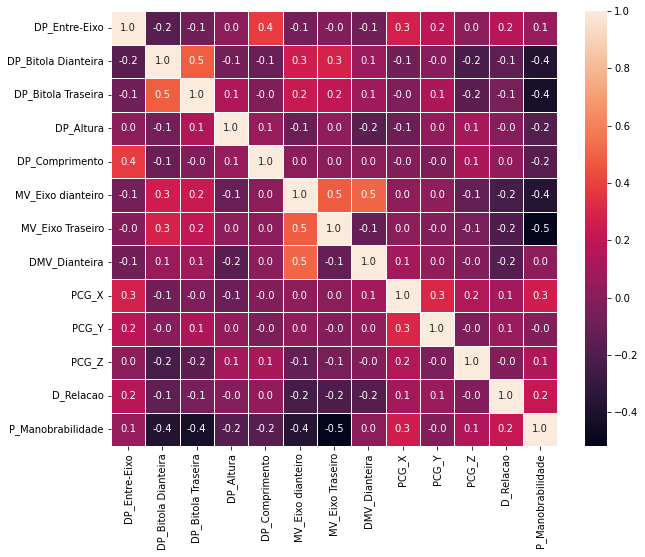

In [18]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [19]:
# Aplicar PCA para reduzir variáveis de alta correlação - Massa
variaveis_reduzidas = df[['MV_Eixo dianteiro', 'MV_Eixo Traseiro']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MV_Eixo dianteiro',
    'MV_Eixo Traseiro',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 5

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Massa', variavel_reduzida)

print(df)

      DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0       1375.000000          1320.000000         1275.000000  1550.000000   
1       1437.352834          1301.084856         1257.383792  1526.436265   
2       1352.624255          1320.913741         1182.351714  1606.885444   
3       1307.150880          1332.524916         1282.562627  1611.635996   
4       1393.831096          1408.554269         1398.255323  1554.642728   
...             ...                  ...                 ...          ...   
995     1458.353300          1291.303150         1196.160187  1391.839336   
996     1500.000000          1297.592843         1210.496743  1464.867874   
997     1514.746926          1261.565233         1191.948088  1533.951251   
998     1371.353579          1302.745066         1202.325865  1534.546076   
1000    1380.000000          1300.000000         1190.000000  1551.720000   

      DP_Comprimento      Massa  DMV_Dianteira       PCG_X      PCG_Y  \
0 

In [20]:
# Aplicar PCA para reduzir variáveis de alta correlação - Bitola
variaveis_reduzidas = df[['DP_Bitola Traseira', 'DP_Bitola Dianteira']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'DP_Bitola Traseira',
    'DP_Bitola Dianteira',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 1

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'DP_Bitola', variavel_reduzida)

print(df)

      DP_Entre-Eixo   DP_Bitola    DP_Altura  DP_Comprimento      Massa  \
0       1375.000000   28.884426  1550.000000     2050.000000  -7.097848   
1       1437.352834    3.190626  1526.436265     2065.013452  -5.338082   
2       1352.624255  -25.757466  1606.885444     2077.082448  -0.121996   
3       1307.150880   43.446108  1611.635996     1982.262142   5.631930   
4       1393.831096  173.548974  1554.642728     1946.073774  26.193643   
...             ...         ...          ...             ...        ...   
995     1458.353300  -41.244089  1391.839336     1932.657829 -14.954655   
996     1500.000000  -27.632705  1464.867874     2018.288445  -6.065963   
997     1514.746926  -67.603412  1533.951251     2021.909241 -24.757674   
998     1371.353579  -28.385616  1534.546076     1977.514112  -6.298810   
1000    1380.000000  -37.953402  1551.720000     1880.000000 -17.863699   

      DMV_Dianteira       PCG_X      PCG_Y       PCG_Z  D_Relacao  \
0          0.417540   65.00000

In [22]:
# Remova a última linha do DataFrame e armazene-a em uma variável separada
dados_MB24 = df.iloc[-1]
df = df.iloc[:-1]

dados_MB24 = dados_MB24.drop('P_Manobrabilidade')

# Converta a série em um DataFrame com uma única linha
dados_MB24 = dados_MB24.to_frame().T

print(dados_MB24)

     DP_Entre-Eixo  DP_Bitola    DP_Altura  DP_Comprimento    Massa  \
998    1371.353579 -28.385616  1534.546076     1977.514112 -6.29881   

     DMV_Dianteira       PCG_X     PCG_Y       PCG_Z  D_Relacao  
998       0.434446  387.199768  0.456156  414.202217   2.884868  


## Balanceamento de Classes

In [23]:
# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [24]:
# Verificar o balanceamento original
print('Contagem de classes antes do SMOTE:', Counter(Y))

Contagem de classes antes do SMOTE: Counter({0.0: 171, 3.0: 156, 1.0: 150, 4.0: 150, 2.0: 124})


In [25]:
# Aplicar SMOTE ao conjunto inteiro
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, Y = smote.fit_resample(X, Y)

In [26]:
# Verificar a contagem de classes após o SMOTE
print('Contagem de classes após o SMOTE:', Counter(Y))

Contagem de classes após o SMOTE: Counter({0.0: 171, 1.0: 171, 2.0: 171, 3.0: 171, 4.0: 171})


In [26]:
# Junte X e Y em um único DataFrame
df = pd.concat([X, Y], axis=1)
print(df)

     DP_Entre-Eixo   DP_Bitola    DP_Altura  DP_Comprimento      Massa  \
0      1375.000000   28.884426  1550.000000     2050.000000  -7.097848   
1      1437.352834    3.190626  1526.436265     2065.013452  -5.338082   
2      1352.624255  -25.757466  1606.885444     2077.082448  -0.121996   
3      1307.150880   43.446108  1611.635996     1982.262142   5.631930   
4      1393.831096  173.548974  1554.642728     1946.073774  26.193643   
..             ...         ...          ...             ...        ...   
850    1481.849126  -80.147178  1456.424786     1936.725255   1.141509   
851    1464.376696  -36.810975  1556.457566     2017.474361 -15.612827   
852    1498.453457    2.006968  1478.475781     2053.261950  -6.709089   
853    1427.930418  -68.932743  1586.107832     1987.493804 -18.982063   
854    1430.000000  -31.976555  1494.905191     1970.000000 -24.324559   

     DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  D_Relacao  \
0         0.417540   65.000000   -4.000000

In [27]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_teste)

     DP_Entre-Eixo   DP_Bitola    DP_Altura  DP_Comprimento      Massa  \
638    1449.956557  -47.166770  1560.295251     1978.436686  -5.634324   
802    1426.914923  -92.896324  1590.919686     2071.556738 -20.088902   
633    1466.449676    6.795481  1635.127954     1993.729221  -3.647209   
471    1427.319890   63.044901  1477.568987     1930.809757   6.543781   
93     1421.835180   99.788983  1497.907198     1924.755510   5.631930   
..             ...         ...          ...             ...        ...   
702    1428.000000 -141.347929  1617.759082     2014.468350  -7.546664   
18     1449.720981   25.241888  1572.978979     2004.584167  26.904816   
577    1479.083009   -5.113641  1477.876941     2072.865690  12.800604   
769    1368.053766   15.567314  1528.403364     1888.922144  -2.445632   
366    1485.759234   27.478573  1732.190564     2031.862377  -0.831881   

     DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  D_Relacao  \
638       0.402164  470.964277  481.210612

In [28]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Treino\\dadostreino_man.xlsx'
nome_da_pagina = 'P_Manobrabilidade'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

dados_treino = xl.parse(nome_da_pagina)

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

In [29]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Teste\\dadosteste_acel.xlsx'
nome_da_pagina = 'P_Aceleration'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

dados_teste = xl.parse(nome_da_pagina)

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

# Pré-seleção do Modelo

## Árvore de Decisão de Classificação

In [30]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

## Classificação de Floresta Aleatória

In [31]:
# Modelo de Classificação de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

## Extreme Gradient Boosting

In [32]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Refinamento do Modelo

## Árvore de Decisão de Classificação

In [33]:
# Exemplo de Tuning
param_grid = {
    'criterion': ['gini', 'entropy'],        # Avaliar a qualidade da divisão
    'max_depth': [5, 10, 15],          # Profundidade máxima das árvores 
    'min_samples_split': [2, 5, 10],         # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],           # Número mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2']   # Número máximo de recursos a serem considerados em cada divisão
}
grid_search = GridSearchCV(estimator=model_DTC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [34]:
# Ajustar um modelo de Árvore de Decisão
model_DTC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_DTC.set_params(**best_params)

DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt')

## Classificação de Floresta Aleatória

In [35]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [10, 20, 30],           # Número de árvores na floresta
    'max_depth': [10, 20, 30],        # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],        # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de amostras em uma folha
    'max_features': [1, 10]        # Número máximo de recursos a serem considerados em cada divisão
}

grid_search = GridSearchCV(estimator=model_RFC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params_RFC = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [36]:
# Ajustar um modelo de Floresta Aleatória
model_RFC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_RFC.set_params(**best_params_RFC)

RandomForestClassifier(max_depth=30, max_features=1, min_samples_split=5,
                       n_estimators=30)

## Extreme Gradient Boosting

In [37]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árvores na floresta
    'max_depth': [3, 4, 5],                # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],          # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],          # Fração de amostras usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],        # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],                # Regularização gamma (parâmetro de penalização)
}

grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params_XGB = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [38]:
# Guardar os parâmetros encontrados fora do código
melhores_parametros = best_params_XGB

# Salvar os melhores parâmetros em um arquivo
joblib.dump(melhores_parametros, 'melhores_parametros_acel.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_acel.pkl')

['melhores_parametros_acel.pkl']

In [39]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params_XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Validação Cruzada

In [40]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Árvore de Decisão de Classificação

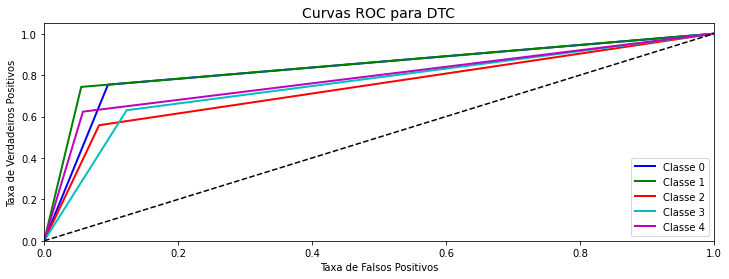

In [41]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_DTC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para DTC', fontsize=14)
plt.show()

In [42]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_DTC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 68.57%
Intervalo de acurácia: [52.50% ~ 84.64%]


In [43]:
# Relatório do modelo
Y_pred = model_DTC.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.7347    0.8000    0.7660        45
         1.0     0.7778    0.8537    0.8140        41
         2.0     0.7500    0.6316    0.6857        38
         3.0     0.6744    0.6444    0.6591        45
         4.0     0.6491    0.6491    0.6491        57

    accuracy                         0.7124       226
   macro avg     0.7172    0.7158    0.7148       226
weighted avg     0.7115    0.7124    0.7104       226



## Classificação de Floresta Aleatória

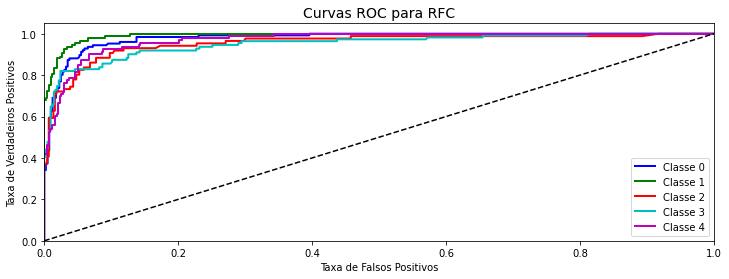

In [44]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para RFC', fontsize=14)
plt.show()

In [45]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_RFC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 85.14%
Intervalo de acurácia: [81.22% ~ 89.07%]


In [46]:
# Relatório do modelo
Y_pred = model_RFC.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.7963    0.9556    0.8687        45
         1.0     0.9512    0.9512    0.9512        41
         2.0     0.8824    0.7895    0.8333        38
         3.0     0.8444    0.8444    0.8444        45
         4.0     0.8846    0.8070    0.8440        57

    accuracy                         0.8673       226
   macro avg     0.8718    0.8695    0.8683       226
weighted avg     0.8707    0.8673    0.8667       226



## Extreme Gradient Boosting

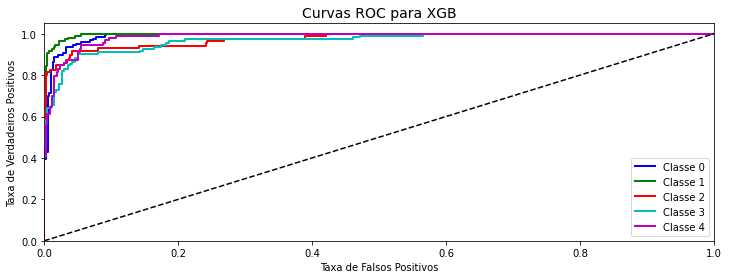

In [47]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para XGB', fontsize=14)
plt.show()

In [48]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 89.33%
Intervalo de acurácia: [84.31% ~ 94.36%]


In [49]:
# Relatório do modelo
Y_pred = model_XGB.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.8125    0.8667    0.8387        45
         1.0     0.9070    0.9512    0.9286        41
         2.0     0.8158    0.8158    0.8158        38
         3.0     0.8636    0.8444    0.8539        45
         4.0     0.9057    0.8421    0.8727        57

    accuracy                         0.8628       226
   macro avg     0.8609    0.8640    0.8619       226
weighted avg     0.8639    0.8628    0.8628       226



# Desempate

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

# Treinamento

In [50]:
# Treinamento do modelo 
model_XGB.fit(X_treino, Y_treino) # Checar modelo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Avaliação

In [51]:
# Fazer previsões no conjunto de teste
Y_pred = model_XGB.predict(X_teste)

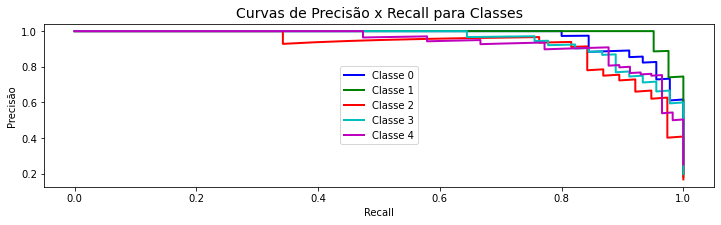

In [52]:
# Comparar scores de Previsão e Recall
# Converta Y_teste para uma matriz binária de classes
Y_bin = label_binarize(Y_teste, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = model_XGB.predict_proba(X_teste)

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

In [53]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
Y_pred = model_XGB.predict(X_teste)

# Calcule a acurácia
accuracy = accuracy_score(Y_teste, Y_pred)

print(f'Acurácia no conjunto de teste: {accuracy:.2f}')

Acurácia no conjunto de teste: 0.89


## Análise de Variáveis 

In [54]:
# Analisar variáveis que mais afetam o modelo
importances = model_XGB.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.08158272 0.08734072 0.06846361 0.06745895 0.16394983 0.1371771
 0.10816726 0.12104982 0.04361756 0.12119236]


[18:57:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[18:57:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 1112/1130 [00:17<00:00]        

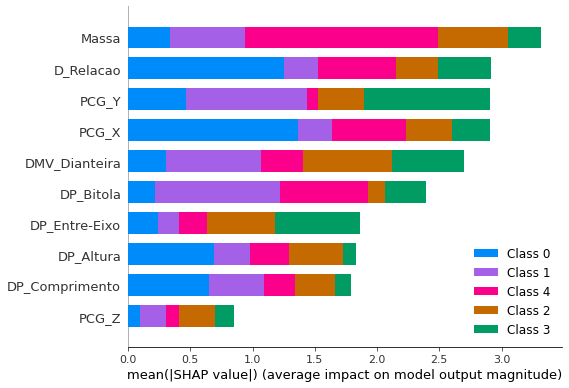

In [55]:
# Crie um objeto explainer
explainer = shap.Explainer(model_XGB, X_teste)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Predição

In [56]:
# Valor único para fazer a previsão
X_prev = dados_MB24

# Faça a previsão
previsao = model_XGB.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')

A previsão para X_prev é: 4.00
